In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
import sys; sys.path.append("/data/jerrylee/pjt/BIGFAM.v.2.0")
from src import obj2
from tqdm import tqdm
import statsmodels.formula.api as smf
from scipy.optimize import minimize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# varying $r_{S,l}$ distribution

In [2]:
def _make_simul_reg(A, X, S, ra, rx, rs, n=1, noise_sd=0.01):
    """Make FR-reg coefficient."""
    by_A = ra * A
    by_X = rx * X
    by_S = rs * S
    by_E = np.random.normal(0, noise_sd, n)
    
    coef = by_A + by_X + by_S + by_E
    
    if len(coef) == 1:
        coef = coef[0]
        
    return coef

def _resamplingFRregCoefficients(df_lmbds, n_resample=100, n_block=10):
    """
    df_lmbds : summary of FR-reg
    """
    df_block = pd.DataFrame()

    for rel_type in df_lmbds["rel_type"].unique():
        df_rel = df_lmbds[df_lmbds["rel_type"] == rel_type].copy()
        dor, rel_type, sex_type, rx, slope, se_slope = df_rel.iloc[0].values

        resampled_slopes = np.random.normal(slope, se_slope, (n_block, n_resample // n_block))
        resampled_slopes = resampled_slopes.flatten()

        df_tmp = pd.DataFrame({
            "DOR": dor,
            "rel_type": rel_type,
            "sex_type": sex_type,
            "rx": rx,
            "slope": resampled_slopes,
            "block": np.repeat(np.arange(n_block), n_resample // n_block),
        })

        df_block = pd.concat([df_block, df_tmp], ignore_index=True)

    return df_block

def _regressOutMean(df_block):
    df_res = df_block.copy()
    # etas = {}

    def regress_out_mean(group):
        ll = smf.ols(formula="slope ~ 1", data=group).fit()
        # etas[group["DOR"].iloc[0]] = 2**group["DOR"].iloc[0] * ll.params["Intercept"]
        group["eta"] = 2**group["DOR"].iloc[0] * ll.params["Intercept"]
        group["residual"] = ll.resid
        group["tl"] = group["rx"] - group["rx"].mean()
        return group

    df_res = df_res.groupby(["block", "DOR"]).apply(regress_out_mean)

    return df_res

def _lossFuncX(x, df, alpha):
    # Fidelity term
    loss_fid = np.sum((df["residual"] - df["tl"] * x) ** 2)

    # L2 term
    loss_l2 = alpha * (x ** 2)

    return loss_fid + loss_l2

def _optToFindX(df_block, alpha):
    x0 = [0.01]
    bounds = [(-1, 1)]

    model = minimize(
        fun=_lossFuncX,
        x0=x0,
        args=(df_block, alpha),
        bounds=bounds,
        tol=1e-6
    )

    return model

# relationships

In [3]:
# load reference familial relationships
df_frreg = pd.read_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/UKB/obj2/frreg/Weight.REL.frreg",
    sep = '\t')
# df_frreg = obj2._matchType(df_frreg)

relations = df_frreg[["DOR", "relationship", "sex_type", "Erx"]]
relations

,DOR,relationship,sex_type,Erx
0,1,daughter-father,FM,0.707107
1,1,daughter-mother,FF,0.500000
2,1,daughter-sister,FF,0.750000
3,1,different-sex-sibling,FM,0.353553
4,1,son-brother,MM,0.500000
5,1,son-father,MM,0.000000
6,1,son-mother,FM,0.707107
7,2,daughter-father-brother,FM,0.353553
8,2,daughter-father-sister,FF,0.250000
9,2,daughter-mother-brother,FM,0.176777


# Distributions of S

0.260621770852542

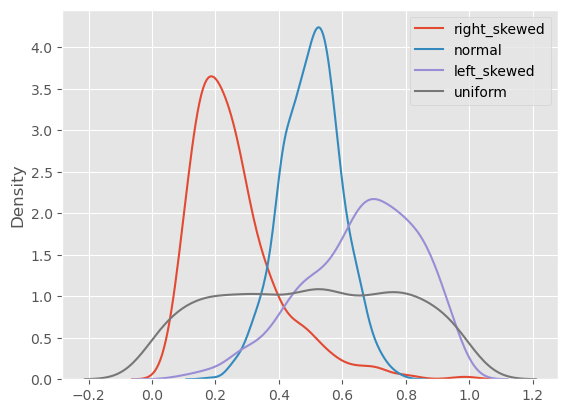

In [5]:
left_skewed = np.clip(np.random.beta(4, 2, 1000), 0, 1)
normal = np.random.normal(0.5, 0.1, 1000)
uniform = np.random.uniform(0, 1, 1000)
right_skewed = np.clip(np.random.lognormal(-1.5, 0.5, 1000), 0, 1)
sns.kdeplot(right_skewed, label="right_skewed")
sns.kdeplot(normal, label="normal")
sns.kdeplot(left_skewed, label="left_skewed")
sns.kdeplot(uniform, label="uniform")
plt.legend()
right_skewed.mean()

In [58]:
# various X
A = 0.4 #0.2
X = A / 20
Ss = [0.2, 0.1, 0.05] # DOR1, DOR2, DOR3
se_frreg = 1e-2

alp = 2 #[-3, -2, -1, 0, 1, 2, 3]
n_resample = 20
n_block = 20

In [64]:
res_cols = ["A_true", "X_true", "distribution", "X", "lower_X", "upper_X"]
df_res = pd.DataFrame(columns=res_cols)
df_raw = pd.DataFrame(columns=[
    "A_true", "X_true", "distribution", "idx", "X"
])

# 100 different shared environmental situations
for idx_s in tqdm(range(100)): 
    
    # simulate FR-reg coefficients
    df_lmbds = pd.DataFrame(columns=["DOR", "rel_type", "sex_type", "rx", "slope", "se_slope"])
    
    for distribution in ["uniform", "normal", "left_skewed", "right_skewed"]:
        for _, row in relations.iterrows():
            # set true parameters
            dor, rel_type, sex_type, rx = row.values
            ra = 0.5**dor
            
            if distribution == "uniform":
                rs = np.random.uniform(0, 1)
            elif distribution == "normal":
                rs = np.random.normal(0.5, 0.1)
            elif distribution == "left_skewed":
                rs = np.random.beta(4, 2, 1)
            elif distribution == "right_skewed":
                rs = np.random.lognormal(-1.5, 0.5, 1)
            
            if rs > 1: rs = 1
            if rs < 0: rs = 0
            
            S = Ss[dor-1]
            
            lmbd = _make_simul_reg(A, X, S, ra, rx, rs, n=1, noise_sd=se_frreg)
            
            df_lmbds.loc[len(df_lmbds)] = [dor, rel_type, sex_type, rx, lmbd, se_frreg]
    
        # resampling for block-jackkinfe
        df_block = _resamplingFRregCoefficients(df_lmbds, n_resample, n_block)
        
        # regress out mean
        df_block = _regressOutMean(df_block)

        # estimate X with SE using resampled FR-reg coefficients
        tmp_Xs = []
        for ib in range(n_block):
            cv_block = df_block[df_block["block"] == ib]
            
            # RIDGE
            mean_eta = cv_block["eta"].mean()
            alpha = ((1/mean_eta)**alp) / cv_block.shape[0]
            
            MODEL = _optToFindX(cv_block, alpha)
            tmp_Xs.append(MODEL.x[0])
        
        tmp_raw = pd.DataFrame({
            "A_true": A,
            "X_true": X,
            "distribution": distribution, 
            "idx": idx_s, 
            "X": tmp_Xs
        })
        df_raw = pd.concat([df_raw, tmp_raw], ignore_index=True)
        df_res.loc[len(df_res)] \
            = [A, X, distribution, np.median(tmp_Xs), np.quantile(tmp_Xs, 0.025), np.quantile(tmp_Xs, 0.975)]

100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


In [65]:
(df_res
 .groupby("distribution")
 .mean())

,A_true,X_true,X,lower_X,upper_X
distribution,,,,,
left_skewed,0.4,0.02,0.019629,0.002263,0.035814
normal,0.4,0.02,0.019475,0.002369,0.035898
right_skewed,0.4,0.02,0.019356,0.001986,0.036377
uniform,0.4,0.02,0.018734,0.001344,0.036013


In [66]:
df_res.to_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/simulation/obj2/simulation.varying-S-distribution.tsv",
    sep='\t',
    index=False
)